Motivation:

from https://www.kaggle.com/rspadim/categorical-variables-feature-tree-optimization/ comment by Nooh:
 
>https://www.kaggle.com/rspadim/categorical-variables-feature-tree-optimization/comments#233465
>"Can you guide a little as what exactly this technique does? Its kinda new to me"

I will write what I was trying to do, and maybe give some idea to logistic regression optimization (but not sure if this is ok)

---

Consider you have two small dataset:

    X=[1,2,3,4,5]
    Y=[0,0,1,0,0]

The problem is: **create a decision tree to reproduce the X->Y relation, consider that tree can only use >= operator, and have max_depth=infinity.**

The most probable tree is:

    if(x>=3): #first depth
        if(x>=4): #second depth
            y=0
        else:     #second depth
            y=1
    else:     #first depth
        y=0

the problem now is: **create the decision tree with max_depth=1, and classification error=0 (overfit it)**. 

answer: **it's not possible without reordering X dataset, all tree will have an classification error**. ok... all trees:

    if(x>=0):
        y=0
    else:
        y=1

    if(x>=1):
        y=0
    else:
        y=1

ok, i will stop here, you will never overfit this dataset with only one depth


in first overfitted tree (depth=2) you have a global if (x>=3), and a second depth with if (x>=4), the only way to do it with only one if is:

change 'x=3' with 'x=1' or 'x=5'. my algorithm is not optimal (it don't converge fast and don't give the best answer allways), first I do a naive algorithm reordering by X features count (maybe by Y is better, but I did a naive algorithm, =) you can optimize it ) and if it didn't converge to 1 depth, run a permutation of all unique values of X, if X unique values length is too big (more than 6 values ≃ 721 permutations if I'm not wrong) I use a random sampling (with a limit of tries) to try new orders (good luck!!!). 

at each new order of X values you create a new tree, if tree depth is smaller (in this case depth=1) than initial tree (in this case depth=2) save the reorder dictionary.


---

"naive" algorithm part:

    #group by X, count X values, sorting by count(X) asc
    first_try=df.groupby(feature_col)[feature_col].count().sort_values(ascending=True)
    l,values_dict=0,{}
    for i in first_try.index:
        values_dict[values[l]]=i
        l+=1
    model=getModel(classifier,tree_seed)
    model.fit(df[feature_col].replace(values_dict).values.reshape(-1,1),df[target_col])

what this will do?

    X[1 -> 1, 2 -> 1, 3->1, 4-> 1, 5->1]

no optimization here, probably tree depth = 2

what we could do? permutation since it's a small dataset: [1,2,3,4,5], [1,2,3,5,4], [1,2,5,3,4] ... but we can do better, let's go to first best answer:

    group by Y:
    Y[0->{1,2,4,5},1->{3}]

now, reorder X values
0 values will be:

    1->0, 2->1, 4-> 2, 5-> 3

1 values will be:

    3->4

new dataset is:

    X=[0,1,2,3,4]
    Y=[0,0,0,0,1]

create the new tree:

    if(X>=4):
        y=1
    else:
        y=0

(i will talk more about it at end of this notebook, it's  just an idea about optimization with unbalanced data)

---

it's a model complexity minimization algorithm, "minimize the (tree depth) subject to reordering categorical features", now we have only 1 if(x>=4)

now logistic regression...

the problem is... how this make betters linear models? I'm not sure about my answer, BUT, from our friend @Eric Vos, "this optimize linear models", why? ordered data is easier to linear models fit =), when linear values are easy to separe with big weights. 

changing X values the new parameters of model Y=logit(weights), can be very small for Y=0 (X<=3) and very big to Y=1 (X>4), but you will see that X=4 is "not good", X=100000000 is "better", from logistic regression (wikipedia, but just to explain what happens in logistic classifier parameters):

ln(pi / (1-pi) = B0 + B1*x1 + ....

pi = 1/(1+exp(- B0 + B1*x1 + ...)

y = 1 / (1+exp(-f(X))

diff(y) = Y(1-y) * df/dX

# Let's code =)

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import log_loss
from graphviz import Source
import matplotlib.pyplot as plt

# DataSets:

I will use 5 datasets to show some things...

1) is normal unsorted data

2) sorted X, X=4 Y=1, all others Y=0

3) one hot encode with only 1 Y=1

4) one hot encode with 2 Y=1

5) same from dataset 2 but with X=5 replaced by X=10000000

In [2]:
# FIRST DATA SET
X1=np.array([[1],[2],[3],[4],[5]])
y1=np.array([[0],[0],[1],[0],[0]]) # with bad y=1 at x=3, we will get depth=2

# REORDERED
X2=np.array([[0],[1],[2],[3],[4]])
y2=np.array([[0],[0],[0],[0],[1]]) # nice x -> y, we will get depth =1

# TEST ONE HOT ENCODE
X3=np.array([[1,0,0,0,0],[0,1,0,0,0],[0,0,1,0,0],[0,0,0,0,1],[0,0,0,0,1]])
y3=np.array([[0],[0],[1],[0],[0]])

# TEST ONE HOT ENCODE (x1=1 and x3=1)
X4=np.array([[1,0,0,0,0],[0,1,0,0,0],[0,0,1,0,0],[0,0,0,0,1],[0,0,0,0,1]])
y4=np.array([[1],[0],[1],[0],[0]])

# TEST LINEAR MODELS:
X5=np.array([[0],[1],[2],[3],[10000000]])  #nice X values, it's good to linear models
y5=np.array([[0],[0],[0],[0],[1]]) # nice x->y

# First, let's see decision trees:


In [3]:
#http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
#    I will set some parameters, the main parameter is class_weight
#
#    criterion
#       The function to measure the quality of a split. 
#       Supported criteria are “gini” for the Gini impurity and 
#       “entropy” for the information gain. <- i like this, but let's use gini...
#
#    class_weight
#        The “balanced” mode uses the values of y to automatically adjust weights 
#        inversely proportional to class frequencies in the input data as 
#
#        weight= n_samples / (n_classes * np.bincount(y))
#        
#    max_depth
#        The maximum depth of the tree. If None, then nodes are expanded until all 
#        leaves are pure or until all leaves contain less than min_samples_split samples.

model=DecisionTreeClassifier(criterion='gini',class_weight='balanced',max_depth=None)

# Dataset 1 - default values

dataset1: 
    depth:   2
    proba:   [ 0.  0.  1.  0.  0.]
    logloss: 9.99200722163e-16


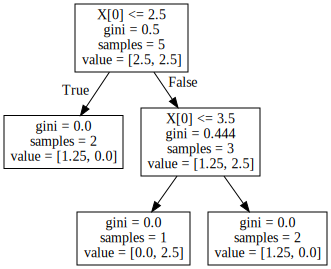

In [4]:
# dataset 1
model.fit(X1,y1)
y_hat1=model.predict_proba(X1)[:,1]
loss1 =log_loss(y1,y_hat1)
print("dataset1: ")
print('    depth:  ',model.tree_.max_depth)
print('    proba:  ',y_hat1)
print('    logloss:',loss1)
#plot tree :)
Source( tree.export_graphviz(model, out_file=None))

Here an important note...

check samples: 

    samples=5
    samples=2, samples=3 -> X values [1,2] , [3,4,5]
    samples=1, samples=2 -> X values [3]   , [4,5]

that's how tree see X values [1,2,3,4,5] / Y [0,0,1,0,0], it cut Y=1 in 3 leafs (box without arrows ≃ final values) with 2 depths

# Dataset 2 - ordered X categories

dataset2: 
    depth:   1
    proba:   [ 0.  0.  1.  0.  0.]
    logloss: 9.99200722163e-16


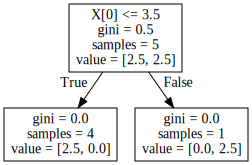

In [5]:
# dataset 2
model.fit(X2,y2)
y_hat2=model.predict_proba(X2)[:,1]
loss2 =log_loss(y2,y_hat2)
print("dataset2: ")
print('    depth:  ',model.tree_.max_depth)
print('    proba:  ',y_hat1)
print('    logloss:',loss1)
#plot tree :)
Source( tree.export_graphviz(model, out_file=None))

check samples: 

    samples=5
    samples=4, samples=1 -> X values [0,1,2,3] , [4]

that's how tree see X values [0,1,2,3,4], only one depth, 2 leafs

# Dataset 5 (big X value)

dataset5: 
    depth:   1
    proba:   [ 0.  0.  0.  0.  1.]
    logloss: 9.99200722163e-16


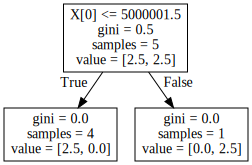

In [6]:
# dataset 5
model.fit(X5,y5)
y_hat5=model.predict_proba(X5)[:,1]
loss5 =log_loss(y5,y_hat5)
print("dataset5: ")
print('    depth:  ',model.tree_.max_depth)
print('    proba:  ',y_hat5)
print('    logloss:',loss5)
#plot tree :)
Source( tree.export_graphviz(model, out_file=None))

same here, but X<= 50000000000000000000000000000000000000000000000 :P

From: https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/discussion/41161#231655
>CPMP
>xgboost is almost insensitive to monotonic feature transformations. What may really change xgboost behavior is a change in the order of values for a given feature.

that's why @CPMP told it, values transformation in one feature column without mixing others features isn't good to trees, BUT, reordering is, it's right just remember that SIN() COS() functions can reorder it too, be carefull with "Non Monotonic" math functions =]

# Decision tree with one hot encode

# Dataset 3 - one Y=1

X= [[1 0 0 0 0]
 [0 1 0 0 0]
 [0 0 1 0 0]
 [0 0 0 0 1]
 [0 0 0 0 1]]
Y= [[0]
 [0]
 [1]
 [0]
 [0]]
dataset3: 
    depth:   1
    proba:   [ 0.  0.  1.  0.  0.]
    logloss: 9.99200722163e-16


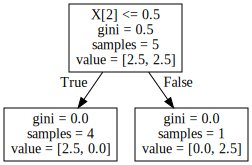

In [7]:
# dataset 3
print('X=',X3)
print('Y=',y3)
model.fit(X3,y3)
y_hat3=model.predict_proba(X3)[:,1]
loss3 =log_loss(y3,y_hat3)
print("dataset3: ")
print('    depth:  ',model.tree_.max_depth)
print('    proba:  ',y_hat3)
print('    logloss:',loss3)
#plot tree :)
Source( tree.export_graphviz(model, out_file=None))


# Dataset 4 - two Y=1

X= [[1 0 0 0 0]
 [0 1 0 0 0]
 [0 0 1 0 0]
 [0 0 0 0 1]
 [0 0 0 0 1]]
Y= [[1]
 [0]
 [1]
 [0]
 [0]]
dataset3: 
    depth:   2
    proba:   [ 0.  0.  1.  0.  0.]
    logloss: 9.99200722163e-16


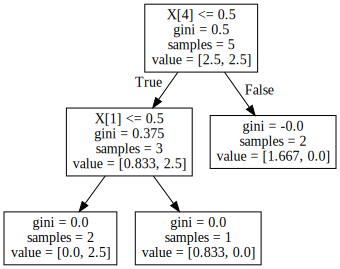

In [8]:
# dataset 4
print('X=',X4)
print('Y=',y4)
model.fit(X4,y4)
y_hat4=model.predict_proba(X4)[:,1]
loss4 =log_loss(y4,y_hat4)
print("dataset3: ")
print('    depth:  ',model.tree_.max_depth)
print('    proba:  ',y_hat3)
print('    logloss:',loss3)
#plot tree :)
Source( tree.export_graphviz(model, out_file=None))


Check that one hot encode, give depth=2 leafs=3, when we could use max depth =1, leafs=2, with sorted categorical variables

That's why you should be carefull with OHE and decision trees!

let's see if decision tree fit Y values well? it must!

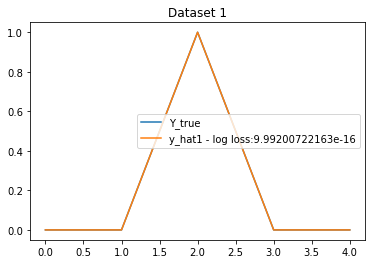

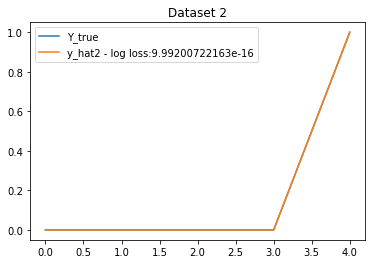

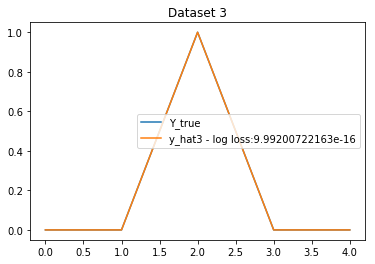

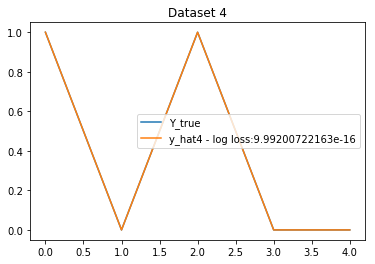

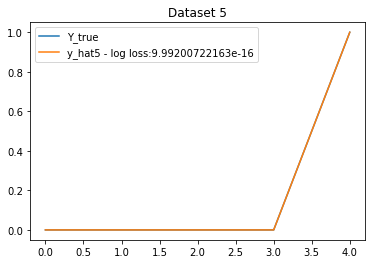

In [9]:
#Y values
plt.title('Dataset 1')
plt.plot(y1,label='Y_true')
plt.plot(y_hat1,label='y_hat1 - log loss:'+str(loss1))
plt.legend()
plt.show()

plt.title('Dataset 2')
plt.plot(y2,label='Y_true')
plt.plot(y_hat2,label='y_hat2 - log loss:'+str(loss2))
plt.legend()
plt.show()

plt.title('Dataset 3')
plt.plot(y3,label='Y_true')
plt.plot(y_hat3,label='y_hat3 - log loss:'+str(loss3))
plt.legend()
plt.show()

plt.title('Dataset 4')
plt.plot(y4,label='Y_true')
plt.plot(y_hat4,label='y_hat4 - log loss:'+str(loss4))
plt.legend()
plt.show()

plt.title('Dataset 5')
plt.plot(y5,label='Y_true')
plt.plot(y_hat5,label='y_hat5 - log loss:'+str(loss5))
plt.legend()
plt.show()

Now, let's see what logistic regression do, I never tryed it before, let's try

In [10]:
#http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
model=LogisticRegression()

# try changing penalty and C hyperparameters :)

In [11]:
model.fit(X1,y1.ravel())
y_hat1=model.predict_proba(X1)[:,1]
loss1 =log_loss(y1,model.predict_proba(X1)[:,1])
print("model1: ")
print('    coefs:  ',model.coef_)
print('    y_true: ',y1.ravel())
print('    proba:  ',y_hat1)
print('    logloss:',loss1)


model1: 
    coefs:   [[-0.28311336]]
    y_true:  [0 0 1 0 0]
    proba:   [ 0.36545738  0.30261671  0.24638589  0.19764243  0.15653904]
    logloss: 0.521313967901


In [12]:
model.fit(X2,y2.ravel())
y_hat2=model.predict_proba(X2)[:,1]
loss2 =log_loss(y2,model.predict_proba(X2)[:,1])
print("model2: ")
print('    coefs:  ',model.coef_)
print('    y_true: ',y2.ravel())
print('    proba:  ',y_hat2)
print('    logloss:',loss2)



model2: 
    coefs:   [[ 0.11699527]]
    y_true:  [0 0 0 0 1]
    proba:   [ 0.30852333  0.33402492  0.36053534  0.38792421  0.41604006]
    logloss: 0.518085142085


In [13]:
model.fit(X3,y3.ravel())
y_hat3=model.predict_proba(X3)[:,1]
loss3 =log_loss(y3,model.predict_proba(X3)[:,1])
print("model3: ")
print('    coefs:  ',model.coef_)
print('    y_true: ',y3.ravel())
print('    proba:  ',y_hat3)
print('    logloss:',loss3)



model3: 
    coefs:   [[-0.29455857 -0.29455857  0.51575158  0.         -0.50542044]]
    y_true:  [0 0 1 0 0]
    proba:   [ 0.29455884  0.29455884  0.48424661  0.25271081  0.25271081]
    logloss: 0.401126174983


In [14]:
model.fit(X4,y4.ravel())
y_hat4=model.predict_proba(X4)[:,1]
loss4 =log_loss(y4,model.predict_proba(X4)[:,1])
print("model4: ")
print('    coefs:  ',model.coef_)
print('    y_true: ',y4.ravel())
print('    proba:  ',y_hat4)
print('    logloss:',loss4)


model4: 
    coefs:   [[ 0.42938511 -0.37324947  0.42938511  0.         -0.63054917]]
    y_true:  [1 0 1 0 0]
    proba:   [ 0.570614    0.37325501  0.570614    0.3152738   0.3152738 ]
    logloss: 0.469354518776


In [15]:
model.fit(X5,y5)
y_hat5=model.predict_proba(X5)[:,1]
loss5 =log_loss(y5,model.predict_proba(X5)[:,1])
print("model5: ")
print('    coefs:  ',model.coef_)
print('    y_true: ',y5.ravel())
print('    proba:  ',y_hat5)
print('    logloss:',loss5)



model5: 
    coefs:   [[  1.21686500e-06]]
    y_true:  [0 0 0 0 1]
    proba:   [ 0.5         0.5000003   0.50000061  0.50000091  0.99999481]
    logloss: 0.554519511777


/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Let's see some plots...

# Dataset 1, 3 have same Y, but 3 have One Hot Encode (nice to logistic regression)

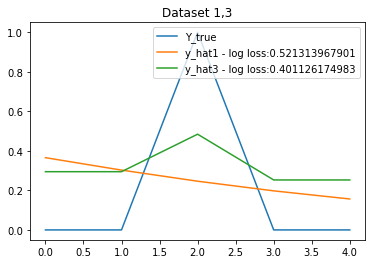

In [16]:
plt.title('Dataset 1,3')
plt.plot(y1,label='Y_true')
plt.plot(y_hat1,label='y_hat1 - log loss:'+str(loss1))
plt.plot(y_hat3,label='y_hat3 - log loss:'+str(loss3))
plt.legend()
plt.show()


# Dataset 2,5 have same Y too

but check how a BIG X value helps a lot!

X2= [0 1 2 3 4] Y2= [0 0 0 0 1]
X5= [       0        1        2        3 10000000] Y5= [0 0 0 0 1]


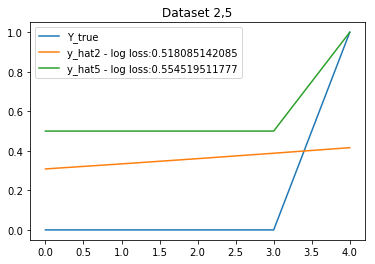

In [17]:
print('X2=',X2.ravel(),'Y2=',y2.ravel())
print('X5=',X5.ravel(),'Y5=',y5.ravel())
plt.title('Dataset 2,5')
plt.plot(y2,label='Y_true')
plt.plot(y_hat2,label='y_hat2 - log loss:'+str(loss2))
plt.plot(y_hat5,label='y_hat5 - log loss:'+str(loss5))
plt.legend()
plt.show()


In this case, only sorting features isn't 100%, but we can use small X values to Y=0, and big to Y=1

for example...  

with a 1000 unique values X dataset, and from x=1 to x=500 we have y=0, and to x=10000 to x=10500 we have Y=1

let's try...

In [18]:
X1=list(range(0,1000))
y1=[0]*500 +[1]*500

X2_10000=list(range(10000,10500))
X2_0    =list(range(0,500))
X2=X2_0+X2_10000
y2=y1

print('X1=',X1)
print('y1=',y1)
print('\n\n-------------------------\n\n')
print('X2=',X2)
print('y2=',y2)

X1= [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 

Let's fit it with logistic regression

In [19]:
X1_v=np.vstack(X1)
model.fit(X1_v,y1)
y_hat1=model.predict(X1_v)
loss1 =log_loss(y1,y_hat1)
print("model1: ")
print('    coefs:  ',model.coef_)
print('    y_true: ',y1)
print('    proba:  ',y_hat1)
print('    logloss:',loss1)

X2_v=np.vstack(X2)
model.fit(X2_v,y2)
y_hat2=model.predict(X2_v)
loss2 =log_loss(y2,y_hat2)
print("model2: ")
print('    coefs:  ',model.coef_)
print('    y_true: ',y2)
print('    proba:  ',y_hat2)
print('    logloss:',loss2)


model1: 
    coefs:   [[ 0.01749354]]
    y_true:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

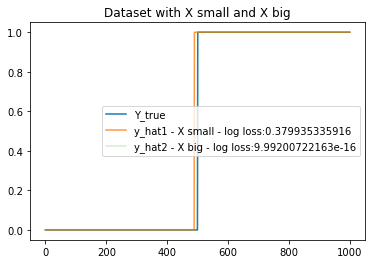

In [20]:
plt.title('Dataset with X small and X big')
plt.plot(y1,label='Y_true')
plt.plot(y_hat1,label='y_hat1 - X small - log loss:'+str(loss1),alpha=.8)
plt.plot(y_hat2,label='y_hat2 - X big - log loss:'+str(loss2),alpha=.2)
plt.legend()
plt.show()


Check that y_hat2 have better log loss!

I think that's all =) good luck!

---
let's go back to unbalanced X-Y and optimization idea, just see what happen when try to implement some categorical optimization



i will implement this new idea soon :), but must check problems with unbalanced data, example: X=3 Y->20% = 0, 80% = 1

    x=[3,3,3,3,3,3,3,4]
    y=[0,1,0,1,0,1,0,1]

what's the best x values? maybe here an global optimization is better, must use try-and-error feedback... but some naive ideas:

    x=3 => y=0 p()=3/7, y=1 p()=4/7
    x=4 => y=1 p()=1

maybe:

    y=1

but using sklearn we check this :

    if(x>=4):
        y=1
    else:
        if(x>=3): (y=0 p()=3/7, y=1 p()=4/7, more probability to y=1 than y=0)
            y=3/7 (i was thinking this could be 1, but not... this should be 4/7 or 3/7, sklearn used 3/7... why? i don't know, but this reduce log loss!)
        else:
            we don't have more data... reduce this if 

reduce everything to

    if(x>=4):
        y=1
    else:
       y=3/7

X= [3 3 3 3 3 3 3 4]
Y= [0, 1, 0, 1, 0, 1, 0, 1]
X-Y: 
    depth:   1
    y_true:  [0, 1, 0, 1, 0, 1, 0, 1]
    proba:   [ 0.42857143  0.42857143  0.42857143  0.42857143  0.42857143  0.42857143
  0.42857143  1.        ]
    logloss: 0.597544591613

What happen if use 4/7 instead of 3/7? let's see log loss only, but each metric give something different
    proba:   [ 0.57142857  0.57142857  0.57142857  0.57142857  0.57142857  0.57142857
  0.57142857  1.        ]
    logloss: 0.633504850669


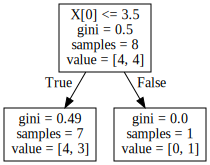

In [21]:
model=DecisionTreeClassifier(criterion='gini',class_weight='balanced',max_depth=None)
x=np.vstack([3,3,3,3,3,3,3,4])
y=[0,1,0,1,0,1,0,1]

# dataset 3
print('X=',x.ravel())
print('Y=',y)
model.fit(x,y)
y_hat_both=model.predict_proba(x)
y_hat_both2=y_hat_both.copy()
y_hat_both2[:,0],y_hat_both2[:,1]=y_hat_both[:,1],y_hat_both[:,0] # inverse
y_hat_both2[7][0]=0
y_hat_both2[7][1]=1

y_hat    =y_hat_both[:,1]
y_hat_4_7=y_hat_both2[:,1]
loss =log_loss(y,y_hat)
loss1=log_loss(y,y_hat_4_7)
print("X-Y: ")
print('    depth:  ',model.tree_.max_depth)
print('    y_true: ',y)
print('    proba:  ',y_hat)
print('    logloss:',loss)

print("\nWhat happen if use 4/7 instead of 3/7? let's see log loss only, but each metric give something different")
print('    proba:  ',y_hat_4_7)
print('    logloss:',loss1)

#plot tree :)
Source( tree.export_graphviz(model, out_file=None))


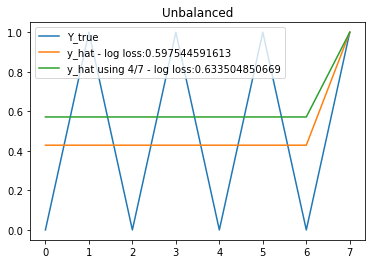

In [22]:
# plot output
plt.title('Unbalanced')
plt.plot(y,label='Y_true')
plt.plot(y_hat,label='y_hat - log loss:'+str(loss))
plt.plot(y_hat_4_7,label='y_hat using 4/7 - log loss:'+str(loss1))
plt.legend()
plt.show()


Let's use this last tree, to check rock auc with different probabilities :)

roc= 0.625 , gini= 0.25
roc= 0.625 , gini= 0.25


/opt/conda/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


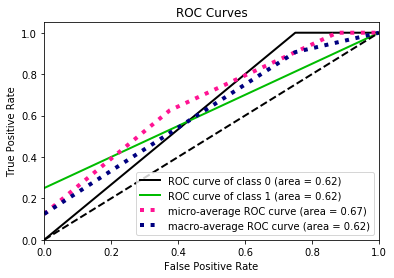

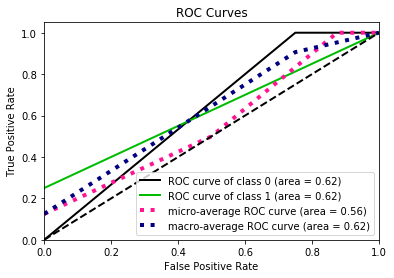

In [23]:
from sklearn.metrics import roc_auc_score
print('roc=',roc_auc_score(y,y_hat)    ,', gini=',roc_auc_score(y,y_hat)*2-1)
print('roc=',roc_auc_score(y,y_hat_4_7),', gini=',roc_auc_score(y,y_hat_4_7)*2-1)

import scikitplot as skplt

skplt.metrics.plot_roc_curve(y, y_hat_both)
plt.show()
skplt.metrics.plot_roc_curve(y, y_hat_both2)
plt.show()